# Simulation of filaments

This notebook tests the simulation of filaments by Monte-Carlo using the 'mixed model'


The normalized model is

In [1]:
import numpy as np
import scipy.optimize as spo
import scipy.integrate as spi
import matplotlib.pyplot as plt

In [22]:
# Helper functions

def machnumber(x):
    if np.abs(x)>1:
        M = 1
    else:
        f = lambda M: 2*np.arctan(M)-M-(0.5*np.pi-1)*np.abs(x)
        M = spo.root_scalar(f,bracket=[0,1]).root
    if x<0:
        return -M
    return M

def tmax(x0,t0):
    # Find the time a particle starting at x(t0)=x0 reaches x=1
    
    # We have dx/dt = M(x), and the particles should disappear at x=1.
    # To find the time for a particle starting at X(t0)=x0 with M(x0)=M0, 
    # we rather integrate dt/dx=1/M(x) with the solution below

    M0 = machnumber(x0)
    return t0+np.log(0.5*(M0+1/M0))/(0.5*np.pi-1)

def sample_from_density(N):
    # We have that the LCFS density proportional to 1/(1+M^2)
    # so we generate samples with this profile using rejection sampling with a uniform
    # proposal density
    def target(x):
        res = np.zeros_like(x)
        for i in range(res.size):
            res[i] = 1/(1+machnumber(x[i])**2)
        return res

    # Find integral of target
    xtmp = np.linspace(0,1,1000)
    integral = np.trapezoid(target(np.linspace(0,1,1000)), np.linspace(0,1,1000))
    average_rejections = 1/integral

    samples = int(1.1*average_rejections*N)
    X = np.random.uniform(size=samples)
    U = np.random.uniform(size=samples)
    good = target(X) > U

    return X[good]

In [42]:
class SimulationParams:
    def __init__(self,dt=0.1):
        self.dt = dt

class Particle:
    def __init__(self,t0=0, x0=0, SimulationParams=SimulationParams()):
        self.params = SimulationParams
        # make time array up to max time
        self.T = np.arange(t0, tmax(x0,t0), self.params.dt)

        # Solve dx/dt = M(x)
        self.X = spi.solve_ivp(lambda t,x: machnumber(x[0]), 
                               (self.T[0],self.T[-1]),
                               np.array([x0,]), t_eval = self.T).y[0]

        # Solution to dR/dt = 1 with R(0)=0
        self.R = self.T-self.T[0]

    def gen_machnumber(self):
        self.M = np.zeros_like(self.T)
        for i in range(self.T.size):
            self.M[i] = machnumber(self.X[i])

7.835
7.835994179469265
3.6550000000000002
3.655055834823938
2.529
2.5290542793656114
1.856
1.8568823024849084
1.381
1.3810664725361859
1.016
1.016879606157762
0.725
0.7259507993162139
0.487
0.4878916517434924
0.29
0.29099959324615465
0.128
0.12882287292235017


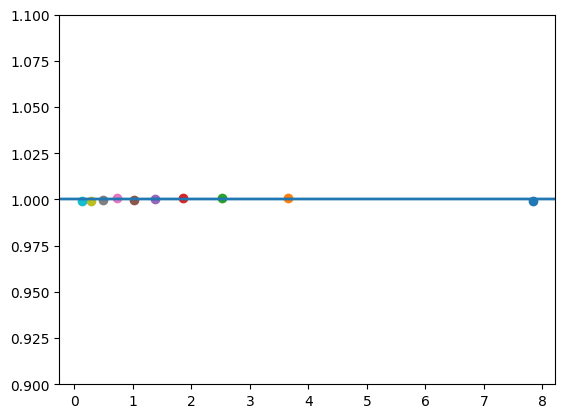

In [51]:
S = SimulationParams(dt=1e-3)

x = np.linspace(0.01,0.9,10)
#plt.figure()
for i in range(x.size):
    P = Particle(x0=x[i],SimulationParams=S)
    print(P.T[-1])
    print(tmax(x[i],0))
    plt.scatter(P.T[-1],P.X[-1])
    plt.ylim(0.9,1.1)
    plt.axhline(1)

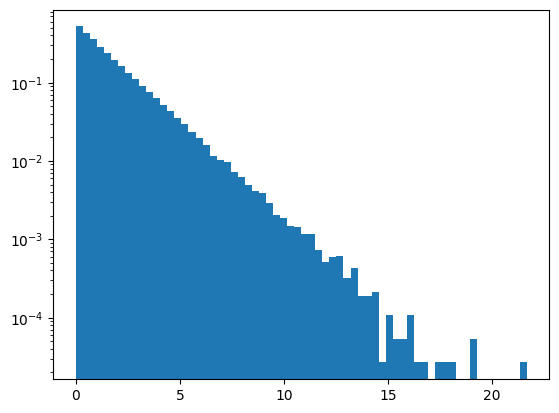

In [40]:
# Find the average exit position
#S = SimulationParams(dt=1e-5)
x0 = sample_from_density(100000)

Xend = [None]*x0.size
for i in range(x0.size):
    Xend[i] = tmax(x0[i],0)

plt.hist(Xend,density=True,log=True,bins=64);

In [29]:
Particle(x0=0.99)

IndexError: list index out of range